### IMPORT LIBRARIES

In [1]:
# 2023034 - MAHMUT ZAHID MALKOC

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, col
from pyspark.sql.types import ArrayType, IntegerType, FloatType
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import when, lit

2023-10-05 01:58:11.102740: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### IMPORT DATASET FROM HDFS

In [2]:
# 2023034 - MAHMUT ZAHID MALKOC

from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("ImageProcessing").getOrCreate()

hdfs_path = "/S2CA1/fer2013.csv"

df = spark.read.csv(hdfs_path, header=True, inferSchema=True)

### EXPLORATORY DATA ANALYSIS USING SPARK

In [3]:
# 2023034 - MAHMUT ZAHID MALKOC

# Show the dataframe
df.show()

+-------+--------------------+--------+
|emotion|              pixels|   Usage|
+-------+--------------------+--------+
|      0|70 80 82 72 58 58...|Training|
|      0|151 150 147 155 1...|Training|
|      2|231 212 156 164 1...|Training|
+-------+--------------------+--------+
only showing top 3 rows



In [4]:
# 2023034 - MAHMUT ZAHID MALKOC

# Select the "emotion" column and find the unique values
unique_emotions = df.select("emotion").distinct().collect()

# Print the unique emotion values to the screen
for row in unique_emotions:
    print(row[0])

1
6
3
5
4
2
0


In [5]:
# 2023034 - MAHMUT ZAHID MALKOC

# Group the "Usage" column and count
usage_counts = df.groupBy("Usage").count()

# Print "usage_counts"
usage_counts.show()

+-----------+-----+
|      Usage|count|
+-----------+-----+
|   Training|28709|
| PublicTest| 3589|
|PrivateTest| 3589|
+-----------+-----+



In [6]:
# 2023034 - MAHMUT ZAHID MALKOC

# Describe the emotion map
emotion_map = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

# Calculate the count of each emotion category
emotion_counts = df.groupBy("emotion").count()

# Print "emotion_counts"
emotion_counts.show()

+-------+-----+
|emotion|count|
+-------+-----+
|      1|  547|
|      6| 6198|
|      3| 8989|
|      5| 4002|
|      4| 6077|
|      2| 5121|
|      0| 4953|
+-------+-----+



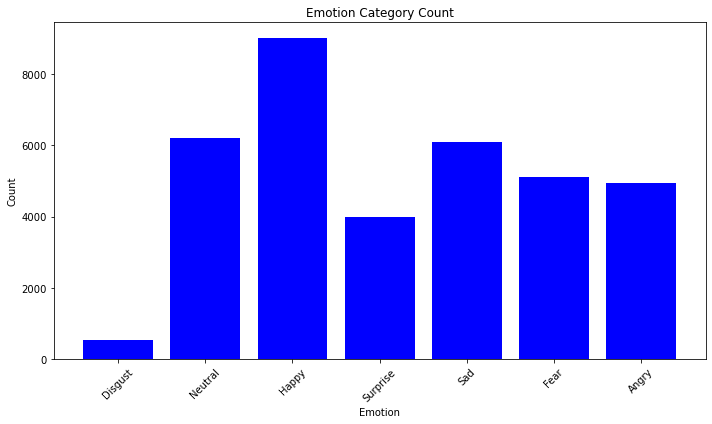

In [7]:
# 2023034 - MAHMUT ZAHID MALKOC

# Describe the labels
emotion_labels = ['Disgust', 'Neutral', 'Happy', 'Surprise', 'Sad', 'Fear', 'Angry']
emotion_counts = [547, 6198, 8989, 4002, 6077, 5121, 4953]

# Plot Bar Graph
plt.figure(figsize=(10, 6))
plt.bar(emotion_labels, emotion_counts, color='blue')

plt.xlabel('Emotion')
plt.ylabel('Count')

plt.title('Emotion Category Count')
plt.xticks(rotation=45)  
plt.tight_layout() 
plt.show()

In [8]:
# 2023034 - MAHMUT ZAHID MALKOC

# Show "pixels" column first 5 rows
df.select("pixels").show(5)

+--------------------+
|              pixels|
+--------------------+
|70 80 82 72 58 58...|
|151 150 147 155 1...|
|231 212 156 164 1...|
|24 32 36 30 32 23...|
|4 0 0 0 0 0 0 0 0...|
+--------------------+
only showing top 5 rows



#### Convert Strings to Lists of Integers

In [9]:
# 2023034 - MAHMUT ZAHID MALKOC

from pyspark.sql.functions import udf, col
from pyspark.sql.types import ArrayType, IntegerType

# Defining a function that converts string data into a list of integers
def string_to_int_list(s):
    return [int(x) for x in s.split()]

# UDF (User Defined Function) function definition
string_to_int_udf = udf(string_to_int_list, ArrayType(IntegerType()))

# Converting the "pixels" column and adding a new column
df = df.withColumn("pixels_as_int", string_to_int_udf(col("pixels")))

# Show the dataframe first 3 rows
df.show(3)

+-------+--------------------+--------+--------------------+
|emotion|              pixels|   Usage|       pixels_as_int|
+-------+--------------------+--------+--------------------+
|      0|70 80 82 72 58 58...|Training|[70, 80, 82, 72, ...|
|      0|151 150 147 155 1...|Training|[151, 150, 147, 1...|
|      2|231 212 156 164 1...|Training|[231, 212, 156, 1...|
+-------+--------------------+--------+--------------------+
only showing top 3 rows



#### Reshape to 48x48 and Normalise Grayscale Image with 255.0

In [10]:
# 2023034 - MAHMUT ZAHID MALKOC

from pyspark.sql.types import FloatType
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

# Normalization process
max_value = 255.0
normalize_udf = udf(lambda x: [v / max_value for v in x], ArrayType(FloatType()))
df = df.withColumn("normalized_pixels", normalize_udf(df["pixels_as_int"]))

# Reshape Dataframe
width = 48
height = 48

reshape_udf = udf(lambda x: [x[i:i+width] for i in range(0, len(x), width)], ArrayType(ArrayType(FloatType())))
df = df.withColumn("reshaped_pixels", reshape_udf(df["normalized_pixels"]))

# Show the dataframe first 3 rows
df.show(3)

+-------+--------------------+--------+--------------------+--------------------+--------------------+
|emotion|              pixels|   Usage|       pixels_as_int|   normalized_pixels|     reshaped_pixels|
+-------+--------------------+--------+--------------------+--------------------+--------------------+
|      0|70 80 82 72 58 58...|Training|[70, 80, 82, 72, ...|[0.27450982, 0.31...|[[0.27450982, 0.3...|
|      0|151 150 147 155 1...|Training|[151, 150, 147, 1...|[0.5921569, 0.588...|[[0.5921569, 0.58...|
|      2|231 212 156 164 1...|Training|[231, 212, 156, 1...|[0.90588236, 0.83...|[[0.90588236, 0.8...|
+-------+--------------------+--------+--------------------+--------------------+--------------------+
only showing top 3 rows



#### Perform One-Hot Encoding Label - e.g. class 3 to [0,0,0,1,0,0,0]

In [11]:
# 2023034 - MAHMUT ZAHID MALKOC

from pyspark.sql.functions import when, lit

# Define emotion mapping
emotion_map = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

# Convert emotion tags to one-hot encoding
for label, emotion in emotion_map.items():
    df = df.withColumn(emotion, when(df["emotion"] == lit(label), 1).otherwise(0))


# Select the "emotion" and one-hot encoding columns before removing the 'emotion' column
selected_columns = ["emotion"] + list(emotion_map.values())

# Show only "selected_columns"
df.select(selected_columns).show()

+-------+-----+-------+----+-----+---+--------+-------+
|emotion|Angry|Disgust|Fear|Happy|Sad|Surprise|Neutral|
+-------+-----+-------+----+-----+---+--------+-------+
|      0|    1|      0|   0|    0|  0|       0|      0|
|      0|    1|      0|   0|    0|  0|       0|      0|
|      2|    0|      0|   1|    0|  0|       0|      0|
|      4|    0|      0|   0|    0|  1|       0|      0|
|      6|    0|      0|   0|    0|  0|       0|      1|
|      2|    0|      0|   1|    0|  0|       0|      0|
|      4|    0|      0|   0|    0|  1|       0|      0|
|      3|    0|      0|   0|    1|  0|       0|      0|
|      3|    0|      0|   0|    1|  0|       0|      0|
|      2|    0|      0|   1|    0|  0|       0|      0|
|      0|    1|      0|   0|    0|  0|       0|      0|
|      6|    0|      0|   0|    0|  0|       0|      1|
|      6|    0|      0|   0|    0|  0|       0|      1|
|      6|    0|      0|   0|    0|  0|       0|      1|
|      3|    0|      0|   0|    1|  0|       0| 

In [12]:
# 2023034 - MAHMUT ZAHID MALKOC

# Show the whole dataset
df.show()

+-------+--------------------+--------+--------------------+--------------------+--------------------+-----+-------+----+-----+---+--------+-------+
|emotion|              pixels|   Usage|       pixels_as_int|   normalized_pixels|     reshaped_pixels|Angry|Disgust|Fear|Happy|Sad|Surprise|Neutral|
+-------+--------------------+--------+--------------------+--------------------+--------------------+-----+-------+----+-----+---+--------+-------+
|      0|70 80 82 72 58 58...|Training|[70, 80, 82, 72, ...|[0.27450982, 0.31...|[[0.27450982, 0.3...|    1|      0|   0|    0|  0|       0|      0|
|      0|151 150 147 155 1...|Training|[151, 150, 147, 1...|[0.5921569, 0.588...|[[0.5921569, 0.58...|    1|      0|   0|    0|  0|       0|      0|
|      2|231 212 156 164 1...|Training|[231, 212, 156, 1...|[0.90588236, 0.83...|[[0.90588236, 0.8...|    0|      0|   1|    0|  0|       0|      0|
|      4|24 32 36 30 32 23...|Training|[24, 32, 36, 30, ...|[0.09411765, 0.12...|[[0.09411765, 0.1...|    

#### Prepare the Dataset for Model Training

In [13]:
# 2023034 - MAHMUT ZAHID MALKOC

# # Select only the required "emotion" and "normalized_pixels" columns
df = df.select("emotion", "normalized_pixels", "Usage")

# Show the special and required dataset
df.show()

+-------+--------------------+--------+
|emotion|   normalized_pixels|   Usage|
+-------+--------------------+--------+
|      0|[0.27450982, 0.31...|Training|
|      0|[0.5921569, 0.588...|Training|
|      2|[0.90588236, 0.83...|Training|
|      4|[0.09411765, 0.12...|Training|
|      6|[0.015686275, 0.0...|Training|
|      2|[0.21568628, 0.21...|Training|
|      4|[0.078431375, 0.0...|Training|
|      3|[0.3019608, 0.305...|Training|
|      3|[0.33333334, 0.32...|Training|
|      2|[1.0, 0.99607843,...|Training|
|      0|[0.11764706, 0.09...|Training|
|      6|[0.15294118, 0.29...|Training|
|      6|[0.85882354, 0.83...|Training|
|      6|[0.5803922, 0.564...|Training|
|      3|[0.015686275, 0.0...|Training|
|      5|[0.41960785, 0.41...|Training|
|      3|[0.05490196, 0.05...|Training|
|      2|[1.0, 1.0, 1.0, 1...|Training|
|      6|[0.5254902, 0.486...|Training|
|      4|[0.85882354, 0.75...|Training|
+-------+--------------------+--------+
only showing top 20 rows



### SPLIT THE DATASET INTO TRAIN - TEST - VALIDATION DATA

In [14]:
# 2023034 - MAHMUT ZAHID MALKOC

# Split the data into 80% train and 20% other
train_data = df.sample(False, 0.8, seed=123)
remaining_data = df.subtract(train_data)

# Split the other into 10% validation and 10% test
validation_data = remaining_data.sample(False, 0.5, seed=123)
test_data = remaining_data.subtract(validation_data)

# Show the shape of data 
print(f"Shape of Train Data     : {train_data.count()     , len(train_data.columns)}")
print(f"Shape of Test Data      : {test_data.count()      , len(test_data.columns)}")
print(f"Shape of Validation Data: {validation_data.count(), len(validation_data.columns)}")

Shape of Train Data     : (28754, 3)


Shape of Test Data      : (3296, 3)


Shape of Validation Data: (3441, 3)


#### Prepare the Dataset for CNN

In [15]:
# 2023034 - MAHMUT ZAHID MALKOC

# Define train_X and train_y - It is better to use array than list for ML/DL
# train_X = train_data.select("normalized_pixels").collect()
# train_Y = train_data.select("emotion").collect()

# Define train_X and train_y
train_X = np.array([row["normalized_pixels"] for row in train_data.collect()])
train_y = np.array([row["emotion"]           for row in train_data.collect()])

# Print train_X and train_y
print("train_X:", len(train_X))
print("train_y:", len(train_y))

train_X: 28754
train_y: 28754


In [16]:
# 2023034 - MAHMUT ZAHID MALKOC

# Define test_X and test_y
test_X = np.array([row["normalized_pixels"] for row in test_data.collect()])
test_y = np.array([row["emotion"]           for row in test_data.collect()])

# Print test_X and test_y
print("test_X :", len(test_X))
print("test_y :", len(test_y))

test_X : 3296
test_y : 3296


In [17]:
# 2023034 - MAHMUT ZAHID MALKOC

# Define val_X and val_y
val_X = np.array([row["normalized_pixels"] for row in validation_data.collect()])
val_y = np.array([row["emotion"]           for row in validation_data.collect()])

# Print val_X and val_y
print("val_X  :", len(val_X))
print("val_y  :", len(val_y))

val_X  : 3441
val_y  : 3441


In [18]:
# 2023034 - MAHMUT ZAHID MALKOC

# RESHAPE TRAIN, TEST AND VAL (X,y)
train_X = train_X.reshape(train_X.shape[0], 48, 48, 1)
test_X  = test_X.reshape(test_X.shape[0], 48, 48, 1)
val_X   = val_X.reshape(val_X.shape[0], 48, 48, 1)

# PRINT TRAIN, TEST AND VAL (X,y)
print("train_X:", len(train_X))
print("test_X :", len(test_X))
print("val_X  :", len(val_X))

train_X: 28754
test_X : 3296
val_X  : 3441


### CNN ARCHITECTURE  

In [19]:
# 2023034 - MAHMUT ZAHID MALKOC

# Initilize Parameters
num_classes = 7 
width, height = 48, 48
num_epochs = 15
batch_size = 64
num_features = 64

In [20]:
# 2023034 - MAHMUT ZAHID MALKOC

from tensorflow.keras.models import Sequential,load_model,Model
from tensorflow.keras.layers import add,Conv2D,BatchNormalization,MaxPooling2D
from tensorflow.keras.layers import Activation,Flatten,Dense,Input
from tensorflow.keras.regularizers import l2

model = tf.keras.Sequential()

# Module 1
model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), input_shape=(width,height,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Module 2
model.add(Conv2D(2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Module 3
model.add(Conv2D(num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Flatten
model.add(Flatten())

# Dense 1
model.add(Dense(2*2*2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))

# Dense 2
model.add(Dense(2*2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))

# Dense 3
model.add(Dense(2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))

# Output Layer
model.add(Dense(num_classes, activation='softmax'))

In [21]:
# 2023034 - MAHMUT ZAHID MALKOC

from keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam

model.compile(loss='categorical_crossentropy', 
              optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7), 
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 256)       2560      
                                                                 
 batch_normalization (Batch  (None, 46, 46, 256)       1024      
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 46, 46, 256)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 256)       590080    
                                                                 
 batch_normalization_1 (Bat  (None, 46, 46, 256)       1024      
 chNormalization)                                                
                                                                 
 activation_1 (Activation)   (None, 46, 46, 256)       0

In [22]:
# 2023034 - MAHMUT ZAHID MALKOC

from keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam

model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7), 
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 256)       2560      
                                                                 
 batch_normalization (Batch  (None, 46, 46, 256)       1024      
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 46, 46, 256)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 256)       590080    
                                                                 
 batch_normalization_1 (Bat  (None, 46, 46, 256)       1024      
 chNormalization)                                                
                                                                 
 activation_1 (Activation)   (None, 46, 46, 256)       0

In [ ]:
# 2023034 - MAHMUT ZAHID MALKOC

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

# Data Generator (Data Augmentation)
data_generator = ImageDataGenerator(featurewise_center=False,
                                    featurewise_std_normalization=False,
                                    rotation_range=10,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    zoom_range=.1,
                                    horizontal_flip=True)
# Early Stopping (Regularization)
es = EarlyStopping(monitor='val_loss', 
                   patience = 10, 
                   mode = 'min', 
                   restore_best_weights=True)

# Model Fit
history = model.fit(data_generator.flow(train_X, train_y, batch_size),
                    steps_per_epoch=len(train_X) / 2*2*batch_size,
                    epochs=3,
                    verbose=2, 
                    callbacks = [es],
                    validation_data=(val_X, val_y))

Epoch 1/3


2023-10-05 04:25:07.273071: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 138674176 exceeds 10% of free system memory.
2023-10-05 04:25:07.390741: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 138674176 exceeds 10% of free system memory.
2023-10-05 04:25:07.585021: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 138674176 exceeds 10% of free system memory.
2023-10-05 04:25:08.294368: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 138674176 exceeds 10% of free system memory.
2023-10-05 04:25:09.219840: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 69337088 exceeds 10% of free system memory.
